In [1]:
from crystalbuilder import *
import crystalbuilder.geometry as geo
import matplotlib.pyplot as plt
import tidy3d as td
import crystalbuilder.convert as cv
import numpy as np
import vedo

In [2]:
a1 = [1, 0, 0]
a2 = [0, 1 ,0]
a3 = [0, 0, 1]

a_mag = .5
geo_lattice = lattice.Lattice(a1, a2, a3, magnitude = [a_mag, a_mag, a_mag])

In [4]:
diamond = bilbao.SpaceGroup(227)
pt = 1/8
points = diamond.calculate_points(point_list=[(pt, pt, pt)]) #This is the 8a wyckoff position

In [5]:
radius = .05
connection_sites = geo.NearestNeighbors(points, radius=radius, neighborhood_range=.45, a_mag = a_mag)
geometry=connection_sites

In [6]:
a1_reps = 8
a2_reps = 8
a3_reps = 4
crystal = geo_lattice.tile_geogeometry(geometry, a1_reps, a2_reps, a3_reps )
# crystal = geometry

In [7]:
scene = viewer.visualize(crystal)
scene.show().close()



In [8]:
newgeo = cv.geo_to_tidy3d(crystal, 2.5)

In [9]:
# create source
lda0 = 0.75  # wavelength of interest (length scales are micrometers in Tidy3D)
freq0 = td.C_0 / lda0  # frequency of interest

source = td.PointDipole(
    center=(0, 0, 0),  # position of the dipole
    source_time=td.GaussianPulse(freq0=freq0, fwidth=freq0 / 10.0),  # time profile of the source
    polarization="Ey",  # polarization of the dipole
) # type: ignore



sim = td.Simulation(
    size=(15, 15, 8),  # simulation domain size
    grid_spec=td.GridSpec.auto(
        min_steps_per_wvl=20
    ),  # automatic nonuniform FDTD grid with 25 grids per wavelength in the material
    structures=[newgeo],
    sources=[source],
    run_time=3e-13,  # physical simulation time in second
) # type: ignore
sim.plot_3d()





In [11]:
from tidy3d import web

task_id = web.upload(sim, task_name="8x8x3-DiamondPhC")
# Load the data through task-id
# sim_data = web.load('fdve-fdebf748-8be8-4117-bc2c-7b11cecdecca')




13:03:31 Central Daylight Time Created task '8x8x3-DiamondPhC' with task_id     
                               'fdve-bebd4a02-ec8f-4d92-8205-dbdc90390f7a' and  
                               task_type 'FDTD'.

                               View task using web UI at                        
                               ]8;id=514898;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bebd4a02-ec8f-4d92-8205-dbdc90390f7a\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=855241;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bebd4a02-ec8f-4d92-8205-dbdc90390f7a\taskId]8;;\
                               ]8;id=514898;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bebd4a02-ec8f-4d92-8205-dbdc90390f7a\=]8;;\]8;id=595484;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bebd4a02-ec8f-4d92-8205-dbdc90390f7a\fdve]8;;\]8;id=514898;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bebd4a02-ec8f-4d92-8205-dbdc90390f7a\-bebd4a02-ec8f-4d92-8205-dbdc90390f7a']8;;\.

                               Task folder: ]8;id=882047;https://tidy3d.simulation.cloud/folders/767b270d-f545-4c6b-9509-691c0e60105a\'default']8;;\.

c:\Users\bgh19\miniconda3\envs\lumerical\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

13:03:42 Central Daylight Time Maximum FlexCredit cost: 0.366. Minimum cost     
                               depends on task execution details. Use           
                               'web.real_cost(task_id)' to get the billed       
                               FlexCredit cost after a simulation run.

<xarray.Dataset> Size: 336B
Dimensions:    (freq: 7)
Coordinates:
  * freq       (freq) float64 56B 2.45e+14 2.752e+14 ... 3.196e+14 3.431e+14
Data variables:
    decay      (freq) float64 56B 9.791e+13 7.318e+13 ... 4.709e+13 3.504e+13
    Q          (freq) float64 56B 7.86 11.82 16.25 17.87 -9.111 21.32 30.76
    amplitude  (freq) float64 56B 1.693 3.042 0.9368 1.564 0.01381 0.8403 1.612
    phase      (freq) float64 56B -0.8525 3.091 1.088 1.108 -2.904 0.3324 -1.46
    error      (freq) float64 56B 0.001447 0.000477 ... 0.001124 0.0007543


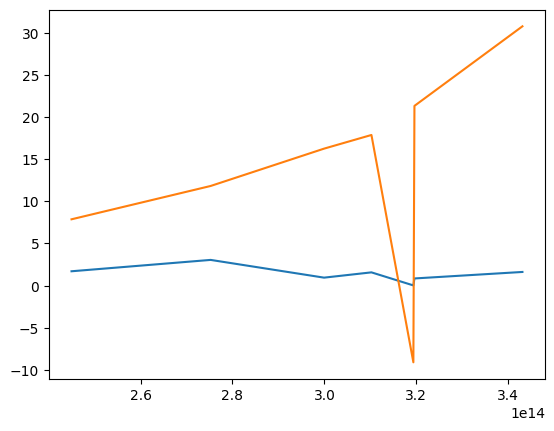

In [ ]:
from tidy3d.plugins.resonance import ResonanceFinder

field = sim_data.load_field_monitor('fieldtimemonitor_3')

resfind = ResonanceFinder(freq_window=[1e14,1e15]).run(field)
print(resfind)
plt.plot(resfind.freq, resfind.amplitude)
plt.plot(resfind.freq, resfind.Q)